## Loading the Data (MNIST)

In [5]:
# following code fetches mnist data set

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
X, y = mnist.data, mnist.target

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


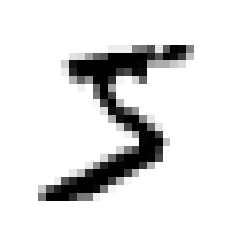

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [23]:
y[0]

'5'

Because Label is string:

In [24]:
y = y.astype(np.uint8)

In [25]:
y[0]

5

### Set test set aside before exploring the data!

Mnist is already separated in train and test set --> first 60.000 train, last 10.000 test (also already shuffled!)
<br>

__NOTE:__ some ml algorithms perform poorly if trainingset ist not shuffled (e.g. multiple similar instances in a row)

In [26]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary Classifier

Only distinguishing between certain number or not certain number

In [27]:
y_train_5 = (y_train == 5) # True for every 5 in train set
y_test_5 = (y_test == 5)

### Training first classifier 

Good start is always Stochastic Gradient Descent (SGD) classifier (Very efficient on big datasets, deals with training instances independently --> good for online learning)

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # stochastik --> classifier relays on randomness
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [30]:
sgd_clf.predict([some_digit]) # --> guessed right in this case!

array([ True])

## Performance Measures

Often significant trickier with classifiers than with regressors --> biggest Part of training Classifiers. <br>
Sometimes it will be necessary to cross_validation yourself (e.g. Chapter 3, page 89)

### Measuring Accuracy Using Cross-Validation

In [33]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Accuracy is very high with over 96% on every fold --> This is only because only 10% of images are 5's ! If the algorithm calssifies every number as not-5, it would have 90% accuracy ...

Thats why accuracy is not the prefered performance measure for classification problems (especially with skewed datasets --> some categories more frequent than others)

### Confusion Matrix 

Better way to evaluated performance of classifier models
Counts the times e.g. a 5 gets confused with other numbers (e.g. 3) --> creates matrix between all numbers

In [37]:
# first a set of predictions is need to which the actual targets can be compared to 
from sklearn.model_selection import cross_val_predict # works same as kfold-cross-validation, just returns predicitons instead of score

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # "clean" set of predicitons on the training set without seeing the test set! 

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) # perfect score has only non-zero values on main diagonal (tleft to bright)


array([[53892,   687],
       [ 1891,  3530]])

In [39]:
# each row predicts an actual class and each column a predicted class
# first row is non-5-class, 53892 correctly classified, 687 wrongly classified
# second row is 5-class, 1891 wrongly classified, 3530 correctly classified

In [40]:
#OTHER PRECISION METRICS

# more concise metric = precision = true positive / (true positive + false positive)
# sensitivity, true positive rate, recall = true positive / (true positive + false negative)

In [42]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [43]:
# --> claims 5 right 83% of the time
# --> only dectets 65% of the 5s

F1_score = way of combining recall and precision into a single metric, to have a simple way to compare two classifiers

In [45]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

__NOTE:__ f1_score favors models with similar precision or recall, sometimes only one of them is relevant.<br>
e.g. for child safe videos you want to reject many good videos (low recall) but keeps only safe ones (high precision) instead of some bad videos comming through (high recall, lower precision)

<br>

On other hand suppose a classifier detecting shoplifter --> you want high recall (99%) and low precision (30%). Some false alerts but all shoplifters will be caught.

In [46]:
# There's always a precision-recall-tradeoff --> increasing one lowers the other (due to threshold value in models)

Accessing the prediciton_function of a classifier to see the theshold value that impacts precision-recall-tradeoffs

In [47]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [49]:
threshold = 0
some_digit_pred = (y_scores > threshold)
some_digit_pred

# 5 gets predicted right as True Positive

array([ True])

If threshold will be increased:

In [50]:
threshold = 8000
some_digit_pred = (y_scores > threshold)
some_digit_pred

# 5 gets predicted wrong as False Negtaive

array([False])

How to decide which threshold to use?

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function') #--> returns decision scores instead of predicitons


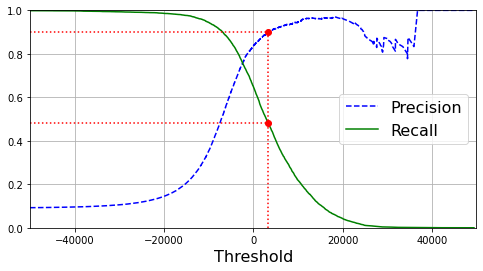

In [56]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])           
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]    

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") # --> markes 90% precision                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()            

For e.g. if you want 90% precision:

In [58]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [59]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Lets check precision and recall on the predicitons with a threshold for 90%

In [61]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### The ROC Curve (receiver operating characteristics)

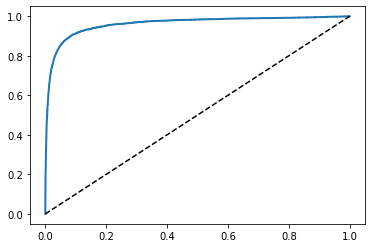

In [63]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

Again the tradoff is vissible, the higher the recall TPR, the more false positives (FPR) the classifier produces

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### comparing ROC of SGDClassifier to RandomForestClassifier

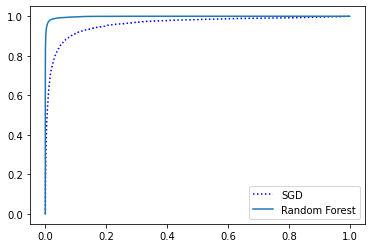

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1] # --> 5's
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [71]:
print(roc_auc_score(y_train_5, y_scores_forest))

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9983436731328145
0.9905083315756169
0.8662608374838591


## Multiclass Classification

Not all Classifiers are natively made for multiclass classification (e.g. SVM, SGDClassifier)
When used for multiclass problem, scikit-leanr automatically runs eather OvR or OvO strategy when detected

In [72]:
from sklearn.svm import SVC # (support vector classifier)

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

It automatically used OvO strategy (trained 45 binary classifiers). To prove this, if decision_function is calles it actually returns 10 per instance with 9.3 as the highest score for 5.

In [73]:
some_digit_scores = svm_clfclf_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [74]:
print(np.argmax(some_digit_scores))

5


If classifier is trained it stores classes in <code>.classes_</code> attribute: 

In [75]:
print(svm_clf.classes_)
print(svm_clf.classes_[np.argmax(some_digit_scores)])

[0 1 2 3 4 5 6 7 8 9]
5


### Training a SGD on Mulitclass Problem

In [76]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [77]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.852  , 0.8443 , 0.87585])

Enhancing prediciton accuracy by adaptinhg the sclaing the X_train data (easy training for model)

In [79]:
from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/Users/Robin/MachineLearning/projects/house-pricing-california/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.89865, 0.9002 , 0.9049 ])